# Adapting Behavior via Intrinsic Reward: A Survey and Empirical Study
## Experiment 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
%matplotlib inline

This notebook is adapted from [the Adapting Behavior via Intrinsic Reward: a Survey and Empirical Study Drifter Distractor notebook](http://jair.adaptingbehavior.com/). In this notebook, we implement experiment 3 and try to reproduce the results from [the research paper](https://arxiv.org/pdf/1906.07865.pdf).

## Experiment Three: Jumpy Eight-Action Problem
This section implementsExperiment Three: Jumpy Eight-Action Problem from the paper. See section 7 and 10 for a description.

In [2]:
def jumpy(steps = 500_000):
    bernoulli = np.random.binomial(size=steps, n=1, p=.005)
    sign = 1
    guassian = np.random.randn(steps) + 10
    b_n = bernoulli * guassian
    arr = [b_n[0]]
    for mu in range(1, steps):
        j = lambda x, zeta: arr[-1] + (zeta * b_n[mu])
        m = j(mu, sign)
    
        if np.abs(m) > 50:
            sign *= -1
            m = j(mu, sign)
    
        arr.append(m)
    return np.array(arr)

In [3]:
def generate_action_data_three(num_steps=500_000):
    #1 jumpy
    #3 noisy
    #2 constant
    #2 drifting
    
    

    # For the distractors each step is a random number chosen from a Normal distribution mean 0.0, var 1.0
    distractor1 = np.random.randn(num_steps)
    distractor2 = np.random.randn(num_steps)
    distractor3 = np.random.randn(num_steps)
    
    # Constant number randomly chosen between [-50, 50]
    constant1 = np.ones(num_steps) * np.random.uniform(-50, 50)
    constant2 = np.ones(num_steps) * np.random.uniform(-50, 50)
    
    # At each step the drifters change slightly by mean 0.0 and variance 0.1
    random_drift1 = np.random.randn(num_steps) * 0.1
    random_drift2 = np.random.randn(num_steps) * 0.1
    drifter1 = np.cumsum(random_drift1)
    drifter2 = np.cumsum(random_drift2)
    
    return np.array([jumpy(num_steps), distractor1, distractor2, distractor3, constant1, constant2, drifter1, drifter2])
    
    

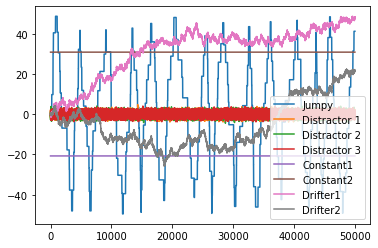

In [4]:
# Plot Actions
plt.plot(generate_action_data_three(50000).T)
plt.legend(["Jumpy","Distractor 1", "Distractor 2","Distractor 3", "Constant1", "Constant2", "Drifter1", "Drifter2"])


## Setup
The setup is the same as the original notebook except for some minor changes in the last two cells.

In [5]:
class Autostep():
    def __init__(self, alpha=1.0, n=1.0, h=0.0, k=0.1):
        self.alpha = alpha
        self.n = n
        self.h = h
        self.k = k

    def update(self, delta):
        self.n = max(np.abs(delta * self.h), 
                     self.n + (1.0/10000.0) * self.alpha * (np.abs(delta * self.h) - self.n))

        self.alpha = min(self.alpha * np.exp(self.k * delta * self.h / self.n), 0.5)
        self.h = self.h * (1 - self.alpha) + (self.alpha * delta)
        return self.alpha, self.h, self.n

In [6]:
class MovingAverage:

    def __init__(self, beta=0.001, one=0.0, method="window"):
        self.avg = 0.0

        # for time based moving average
        self.t = 0

        # for windowed moving average
        self.one = one
        self.beta = beta

        self.method = method

    def update(self, x):

        if self.method == "window":
            self.one = ((1.0 - self.beta) * self.one) + (self.beta * 1.0)
            rate = self.beta / self.one
            self.avg = ((1.0 - rate) * self.avg) + (rate * x)

        if self.method == "time":
            self.t += 1
            self.avg += (x - self.avg) / self.t

        return self.avg

class IncrementalVariance:

    def __init__(self, beta=0.001, one=0.0, method="window"):
        self.sample_mean = MovingAverage(beta=beta, one=one, method=method)
        self.moving_variance = MovingAverage(beta=beta, one=one, method=method)
        self.type = method
        self.differences = []


    def update(self, x):

        old_mean = self.sample_mean.avg

        # update mean
        self.sample_mean.update(x)

        # update variance
        var_sample = (x - old_mean) * (x - self.sample_mean.avg)

        self.moving_variance.update(var_sample)

        return self.moving_variance.avg

In [7]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def select_action(probs):
    return np.random.choice(8, p=probs)

In [8]:
class IntrinsicReward:
    def __init__(self):
        self.prediction = 0.0
        self.stepsize = 0.0
        self.autostep_learner = None
        self.is_introspective = None

    def update_prediction(self, x):
        delta = x - self.prediction

        if self.is_introspective:
            self.autostep_learner.update(delta)
            stepsize = self.autostep_learner.alpha
        else:
            stepsize = self.stepsize

        self.prediction += stepsize * delta

        return delta

class ErrorDerivative(IntrinsicReward):
    def __init__(self, stepsize=0.03125, is_introspective=False, **kwargs):
        self.stepsize = stepsize
        self.is_introspective = is_introspective
        self.eta = kwargs.get("eta", 1000)
        self.tau = kwargs.get("tau", 100)
        self.squared_errors = []
        self.prediction = 0.0

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):

        delta = self.update_prediction(x)

        self.squared_errors.append(np.square(delta))
        length = len(self.squared_errors)     

        if length > (self.eta + self.tau + 1):
            first = (1.0 / (self.eta + 1)) * np.sum(self.squared_errors[-(self.eta+self.tau+1):-self.tau])
            second = (1.0 / (self.eta + 1)) * np.sum(self.squared_errors[-(self.eta+1):])
            return np.abs(first - second)
        else:
            return 0.0

class ExpectedError(IntrinsicReward):
    def __init__(self, stepsize=0.0625, is_introspective=False, **kwargs):
        self.stepsize = stepsize
        self.is_introspective = is_introspective
        self.one = 0.0
        self.beta = kwargs.get("beta", 0.01)
        self.delta_bar = 0.0
        self.prediction = 0.0

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        self.one = (1.0 - self.beta) * self.one + self.beta * 1.0
        rate = self.beta / self.one
        self.delta_bar = (1.0 - rate) * self.delta_bar + rate * delta

        return np.abs(self.delta_bar)

class StepSizeChange(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.previous_stepsize = 0.0
        self.is_introspective = is_introspective

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        if self.is_introspective:
            stepsize = self.autostep_learner.alpha
        else:
            stepsize = 0.0

        stepsize_change = np.abs(self.previous_stepsize - stepsize)
        self.previous_stepsize = stepsize

        return stepsize_change

class BayesianSurprise(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        self.previous_prediction = 0.0
        self.previous_variance = 0.0
        self.eta = 1.0
        self.b = kwargs.get("beta", 0.01)

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        self.b = 0.01
        self.eta = (1 - self.b) * self.eta + 1.0

        welfords_var = (1 - self.b) * self.previous_variance + self.b * (x - self.previous_prediction) * \
            (x - self.prediction)
        var = max(welfords_var / self.eta, 10**-2)

        if var != 0.0 and self.previous_variance != 0.0:
            first = 0.5 * np.log2(var / self.previous_variance)
            second = self.previous_variance + np.square(self.previous_prediction - self.prediction) / (2 * var)
            im_reward = first + second - 0.5
        else:
            im_reward = 0.0

        self.previous_variance = np.copy(var)
        self.previous_prediction = np.copy(self.prediction)

        return im_reward

class UDE(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        self.one = 0.0
        self.beta = kwargs.get("beta", 0.01)
        self.delta_bar = 0.0

        self.count = 0

        self.delta_squared_avg = MovingAverage(method="time")
        self.delta_avg = MovingAverage(method="time")

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        self.count += 1
        delta = self.update_prediction(x)

        self.one = (1.0 - self.beta) * self.one + self.beta * 1.0
        rate = self.beta / self.one
        self.delta_bar = (1.0 - rate) * self.delta_bar + rate * delta

        s_bar = self.delta_squared_avg.update(np.square(delta))
        x_bar = self.delta_avg.update(delta)

        if self.count > 30:
            count = self.delta_avg.t
            denom = np.sqrt((s_bar / count) - np.square(x_bar / count))
            im_reward = np.abs(self.delta_bar / (denom + 0.00001))
        else:
            im_reward = 0.0

        return im_reward

class UncertaintyChange(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        self.beta = kwargs.get("beta_var", 0.001)

        self.variance = IncrementalVariance(beta=self.beta)
        self.previous_variance = 0.0

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        var = self.variance.update(self.prediction)
        im_reward = np.abs(self.previous_variance - var)
        self.previous_varaiance = var

        return im_reward

class VarianceOfPrediction(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        self.variance = IncrementalVariance()

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        im_reward = self.variance.update(self.prediction)

        return im_reward

class WeightChange(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        if self.is_introspective:
            self.stepsize = self.autostep_learner.alpha

        return np.abs(self.stepsize * delta)

In [35]:
def choose_reward_exp3(name, is_introspective):
    if name == "Error Derivative":
        if is_introspective:
            return (ErrorDerivative(stepsize=1.0,
                                    is_introspective=True),
                    0.007812,
                    {"beta_r": 0.0001,
                     "eta": 1000,
                     "tau": 1})
        else:
            return (ErrorDerivative(stepsize=0.03125,
                                   is_introspective=False),
                    0.25,
                    {"beta_r": 0.001,
                     "eta": 1000,
                     "tau": 100})

    elif name == "Expected Error":
        if is_introspective:
            return (ExpectedError(stepsize=1.0,
                                  is_introspective=True),
                    0.007812,
                    {"beta_r": 0.00001,
                     "beta": 0.001})
        else:
            return (ExpectedError(stepsize=0.0625,
                                  is_introspective=False),
                    0.125,
                    {"beta_r": 0.1,
                     "beta": 0.1})

    elif name == "Step-size Change":
        if is_introspective:
            return (StepSizeChange(stepsize=1.0,
                                  is_introspective=True),
                    0.003906,
                    {"beta_r": 0.0001})
        else:
            return (StepSizeChange(stepsize=0.1,
                                  is_introspective=False),
                    0.1,
                    {"beta_r": 0.001})

    elif name == "Bayesian Surprise":
        if is_introspective:
            return (BayesianSurprise(stepsize=1.0,
                                     is_introspective=True),
                    0.007812,
                    {"beta_r": 0.1,
                     "beta": 0.01})
        else:
            return (BayesianSurprise(stepsize=0.125,
                                     is_introspective=False),
                    0.007812,
                    {"beta_r": 0.0001,
                     "beta": 0.01})

    elif name == "UDE":
        if is_introspective:
            return (UDE(stepsize=1.0,
                        is_introspective=True),
                    0.003906,
                    {"beta_r": 0.01,
                     "beta": 0.01})
        else:
            return (UDE(stepsize=0.0625,
                        is_introspective=False),
                    0.125,
                    {"beta_r": 0.1,
                     "beta": 0.1})

    elif name == "Uncertainty Change":
        if is_introspective:
            return (UncertaintyChange(stepsize=1.0,
                                      is_introspective=True),
                    0.0625,
                    {"beta_r": 0.1,
                     "beta_var": 0.1})
        else:
            return (UncertaintyChange(stepsize=0.0625,
                                      is_introspective=False),
                    0.25,
                    {"beta_r": 0.01,
                     "beta_var": 0.01})

    elif name == "Variance of Prediction":
        if is_introspective:
            return (VarianceOfPrediction(stepsize=1.0,
                                         is_introspective=True),
                    0.007812,
                    {"beta_r": 0.1})
        else:
            return (VarianceOfPrediction(stepsize=0.125,
                                         is_introspective=False),
                    0.007812,
                    {"beta_r": 0.1})

    elif name == "Weight Change":
        if is_introspective:
            return (WeightChange(stepsize=1.0,
                                 is_introspective=True),
                    0.015625,
                    {"beta_r": 0.1})
        else:
            return (WeightChange(stepsize=0.0625,
                                 is_introspective=False),
                    0.007812,
                    {"beta_r": 0.1})

In [40]:
class BehaviorAgent:
    def __init__(self, behavior_stepsize, intrinsic_reward, is_introspective, *args, **kwargs):
        self.intrinsic_rewards = [choose_reward_exp3(intrinsic_reward, is_introspective)[0] for _ in range(8)]
        self.one = 0.0
        self.r_bar = 0.0
        self.beta = kwargs.get("beta_r", 0.1)
        self.behavior_stepsize = behavior_stepsize
        self.action_values = np.zeros(8)
        self.probs = np.ones(8) / 8

    def calculate_probs(self):
        self.probs = softmax(self.action_values)

    def choose_action(self):
        self.calculate_probs()
        return select_action(self.probs)

    def update(self, x, chosen_action):
        # get intrinsic_reward
        im_reward = self.intrinsic_rewards[chosen_action].update(x)

        # update_average_reward
        self.one = (1.0 - self.beta) * self.one + self.beta * 1.0
        rate = self.beta / self.one
        self.r_bar = (1.0 - rate) * self.r_bar + rate * im_reward

        # Update the actions values based on the intrinsic reward
        for action in range(8):
            self.action_values[action] += self.behavior_stepsize * (im_reward - self.r_bar) * \
                ((action==chosen_action) * 1.0 - self.probs[action])

In [41]:
def run_experiment(is_introspective=True, record_stepsizes=False,
                   intrinsic_reward="Error Derivative"):
    data = generate_action_data_three()
    track_probs = []
    track_stepsizes = []
    behavior_agent = BehaviorAgent(choose_reward_exp3(intrinsic_reward, is_introspective)[1], 
                                    intrinsic_reward,
                                   is_introspective,
                                   **choose_reward_exp3(intrinsic_reward, is_introspective)[2])
    
                                       
    for i, step_data in enumerate(data.T):
        chosen_action = behavior_agent.choose_action()

        behavior_agent.update(step_data[chosen_action], chosen_action)

        track_probs.append(np.copy(behavior_agent.probs))

        if record_stepsizes:
            track_stepsizes.append(np.copy(np.array([learner.autostep_learner.alpha \
                                                     for learner in behavior_agent.intrinsic_rewards])))

    return np.array(track_probs), np.array(track_stepsizes)

In [42]:
def run():
    output = widgets.Output()
    button = widgets.Button(description="Run Experiment")

    choose_reward = widgets.Dropdown(
        options=["Error Derivative", "Expected Error", "Step-size Change",
                "Bayesian Surprise",  "UDE", "Uncertainty Change",
                "Variance of Prediction", "Weight Change"],
        value="Weight Change",
        description="Choose Reward:",
        disabled=False,
        style={'description_width': 'initial'},
    )

    choose_runs = widgets.IntText(description="Choose number of runs:", value=2, style={'description_width': 'initial'})

    def reset_displays():
        clear_output()
        display(choose_reward)
        display(choose_runs)
        display(button)

    def on_button_click(b):
        reset_displays()
        reward = choose_reward.value
        print("Running")
        runs = [run_experiment(intrinsic_reward=reward)[0] for _ in range(choose_runs.value)]
        action_probs = np.mean(runs, axis=0)
        with output:
            plt.figure(figsize=(4,5))
            colors = ["red", "black", "blue", "green","cyan","orange","brown","purple"]
            for action, color in zip(action_probs.T, colors):
                plt.plot(action, color=color)
            plt.ylim([0.0, 1.01])

    button.on_click(on_button_click)
    reset_displays()

In [43]:
run()

Dropdown(description='Choose Reward:', index=7, options=('Error Derivative', 'Expected Error', 'Step-size Chan…

IntText(value=3, description='Choose number of runs:', style=DescriptionStyle(description_width='initial'))

Button(description='Run Experiment', style=ButtonStyle())

Running


# Reproducibility

The figure shown in [the problem section](#Experiment-Three:-Jumpy-Eight-Action-Problem) follows the equivalent figure in the research paper.

When it comes to the experiment results, the following match, the figures shown in the research paper:
- Weight Change
- Variance of Prediction
- UDE
- Bayesian Surprise
- Step-size change
- Expected Error
- Error Derivative


The following experiments results in this notebook did not match the ones in the research paper:
- Uncertainty Change

## Interpretation
We conclude that our implementation of the second experiment. The first figure of the target data matches the one in the research paper. We were able to reproduce most of the results. For the other half, it might be mostly due to a lack of time to test more. As mentioned in the research paper, the figure with the behaviour agent shows the optimal hyperparameters. As we were playing with different hyperparameters out of the many combinations, we were able to reproduce some and get very close with others but ultimately could not recreate all the results. We did reach out to the authors of the paper to get their hyperparameters which greatly helped.